[View in Colaboratory](https://colab.research.google.com/github/lnarasimhan83/MachineLearning/blob/master/Lakshmi_Narasimhan_Batch_B.ipynb)

#Style Transfer Using Densent & Keras   
####- Lakshmi Narasimhan Batch B  


##Introduction 

Ever wondered how the apps like [Prisma](https://prisma-ai.com/)  works ? A photo from the camera and a design image together producing a new image with content from photo and style from the design image. This is possible with a technique called **style transfer** in deep learning. 

The main idea behind style transfer is to take two images, say, a photo of a person, and a painting, and use these to create a third image that combines the content of the former with the style of the later. 

It all started with Gayts et al publishing a paper on [artistic style transfer](https://arxiv.org/abs/1508.06576)

###Example:

#### Source Image Content

![Content Image](http://www.tatiluzmani.tv/wp-content/uploads/2014/10/Philadelphia-City-Hall-Philadelphia-USA.jpg)

# +

#### Source Image Style
![Style Image](https://cdn-images-1.medium.com/max/1000/1*YXgRwtadXBaW2IP2CQn4tQ.jpeg)


#### = Final Image (Output + Style)
![Final Image](https://cdn-images-1.medium.com/max/1000/1*F1R9CJfhe6uh8803Fru6wQ.jpeg)




## Image Style Transfer

According to the academic literature, image style transfer is defined as follow: given two images on the input, synthesize a third image that has the semantic content of the first image and the texture/style of the second. To work properly we need a way to (1) determine the content and the style of any image (content/style extractor) and then (2) merge some arbitrary content with another arbitrary style (merger).

![Image](https://blog.paperspace.com/content/images/2017/02/Untitled-Diagram-4-.png)


#### Lets get down to business - THE CODE



In [50]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications import DenseNet121


from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import copy

import requests
from io import BytesIO
from io import StringIO
import IPython.display

In [49]:
!pip install cStringIO

  Could not find a version that satisfies the requirement cStringIO (from versions: )
No matching distribution found for cStringIO


In [3]:
# Code for uploading files
from scipy.misc import imread, imsave, imresize
from google.colab import files
import numpy as np
def upload_files():
  
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

list1 = upload_files()
print (list1)
train_file = list1[0]

Saving WAVE.png to WAVE.png
['WAVE.png']


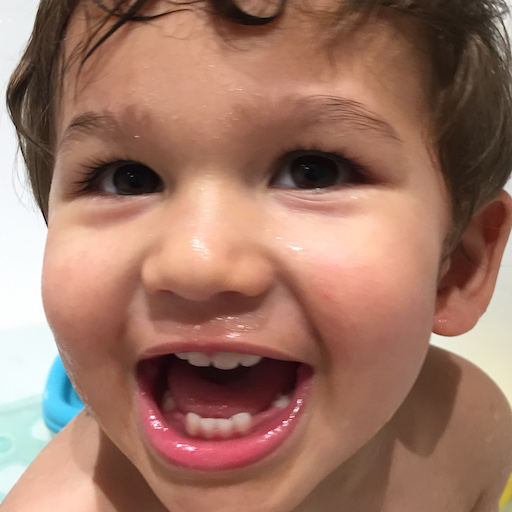

In [4]:
height = 512
width = 512
from PIL import Image
content_image_path = './HUGO.png'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image


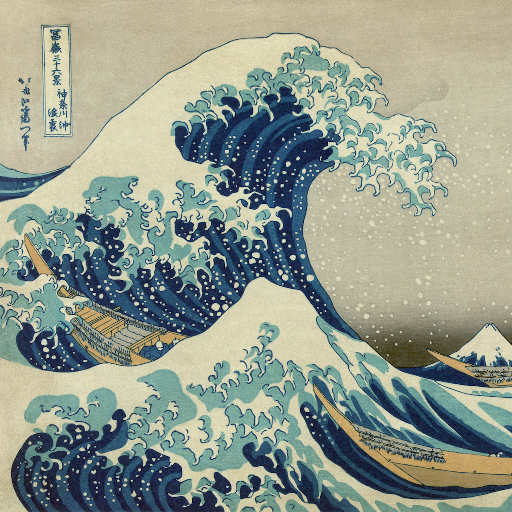

In [5]:
style_image_path = 'WAVE.png'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

Now, we have convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [6]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


## Data Pre-Processing 

Data Pre-Processing is done in two steps 
  1. Subtract Mean RGB value ( Computed on the IMAGENET dataset)
  2. Flip the ordering of Multi-dimensional array from RGB to BGR 
  
## 1. Subtract Mean RGB Values
This step has been suggested in this paper by [Karen Simonyan & Andrew Zisserman](https://arxiv.org/abs/1409.1556)
 
 From the paper:
 *"During training, the input to our ConvNets is a fixed-size 224 × 224 RGB image. The only preprocessing
we do is subtracting the mean RGB value, computed on the training set, from each pixel.""*

#### Why we do this ?
Mean subtraction is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension

Also, We'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier)

Further information explained in this paper [CS231-NN2](http://cs231n.github.io/neural-networks-2/)

## 2. RGB -> BGR

BGR is the ordering used in the paper. 

In general info on why we use BGR instead of RGB can be found at [OpenCV Paper](https://www.learnopencv.com/why-does-opencv-use-bgr-color-format/)


In [7]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [8]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [9]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

##Reuse a model pre-trained for image classification to define loss functions

The core idea introduced by Gatys et al. (2015) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the feature spaces provided by one such model to independently work with content and style of images.

The original paper uses the 19 layer VGG network model from Simonyan and Zisserman (2015), but we're going to instead use Densetn121

Also, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the part of the model marked in green in the table below.

![Densenet Architecture](https://cdn-images-1.medium.com/max/2000/1*gAGIm5uaaUukJOSzMW6saQ.jpeg)


As seen above, for DenseNet-121 there are 121 layers (1 right after Input Layer, 116 from Dense Block, 3 from Transition Layer & 1 FC Layer).

It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including the DenseNet121 model we're interested in. Note that by setting include_top=False in the code below, we don't include any of the fully connected layers







In [10]:
model = DenseNet121(input_tensor=input_tensor, weights='imagenet',
                    include_top=False)

30015488/30011760 [==============================] - 2s 0us/step


In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'bn': <tf.Tensor 'bn/cond/Merge:0' shape=(3, 16, 16, 1024) dtype=float32>,
 'conv1/bn': <tf.Tensor 'conv1/bn/cond/Merge:0' shape=(3, 256, 256, 64) dtype=float32>,
 'conv1/conv': <tf.Tensor 'conv1/conv/convolution:0' shape=(3, 256, 256, 64) dtype=float32>,
 'conv1/relu': <tf.Tensor 'conv1/relu/Relu:0' shape=(3, 256, 256, 64) dtype=float32>,
 'conv2_block1_0_bn': <tf.Tensor 'conv2_block1_0_bn/cond/Merge:0' shape=(3, 128, 128, 64) dtype=float32>,
 'conv2_block1_0_relu': <tf.Tensor 'conv2_block1_0_relu/Relu:0' shape=(3, 128, 128, 64) dtype=float32>,
 'conv2_block1_1_bn': <tf.Tensor 'conv2_block1_1_bn/cond/Merge:0' shape=(3, 128, 128, 128) dtype=float32>,
 'conv2_block1_1_conv': <tf.Tensor 'conv2_block1_1_conv/convolution:0' shape=(3, 128, 128, 128) dtype=float32>,
 'conv2_block1_1_relu': <tf.Tensor 'conv2_block1_1_relu/Relu:0' shape=(3, 128, 128, 128) dtype=float32>,
 'conv2_block1_2_conv': <tf.Tensor 'conv2_block1_2_conv/convolution:0' shape=(3, 128, 128, 32) dtype=float32>,
 'conv2_bloc

In [12]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [13]:
loss = backend.variable(0.)

In [45]:
class Evaluator(object):

    def __init__(self, f_outputs):
        self.loss_value = None
        self.grads_values = None
        self.f_outputs = f_outputs

    def eval_loss_and_grads(self, x):
        x = x.reshape((1, height, width, 3))
        outs = self.f_outputs([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        return loss_value, grad_values

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = self.eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


### The content loss
For the content loss, we follow Johnson et al. (2016) and draw the content feature from block2_conv2, because the original choice in Gatys et al. (2015) (block4_conv2) loses too much structural detail. And at least for faces, I find it more aesthetically pleasing to closely retain the structure of the original content image.

This variation across layers is shown for a couple of examples in the images below (just mentally replace reluX_Y with our Keras notation blockX_convY).

![alt text](https://github.com/hnarayanan/artistic-style-transfer/raw/05c95e5ac7001201d1ae9bf734a9224cf3445388/notebooks/images/content-feature.png
)

In [53]:
def visualise_img(x):
    x_p = copy.deepcopy(x)
    x_p = x_p.reshape((height, width, 3))
    x_p = np.clip(x_p, 0, 255).astype('uint8')
    f = BytesIO()
    Image.fromarray(x_p).save(f, 'png')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))


def content_image_reconstruction(layer_name):
  layer_features = layers[layer_name]
  content_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = content_loss(content_image_features,
                                       combination_features)

  grads = backend.gradients(loss, combination_image)
  outputs = [loss]
  outputs += grads
  f_outputs = backend.function([combination_image], outputs)

  evaluator = Evaluator(f_outputs)  

  x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

  iterations = 10
  
  # print layer-name & number of iterations
  title = layer_name + " (%d-iters):" % (iterations)
  print(title)
  print('='*len(title))
  for i in range(iterations):
      start_time = time.time()
      x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                       fprime=evaluator.grads, maxfun=20)
      end_time = time.time()
      
      # print loss value & time taken in iteration i
      # format: loss(time-in-seconds)
      print("%.2f(%ds)," % (min_val, end_time - start_time), end='')
      
      # print new line so that we don't exceed way out of screen
      if (i % 10 == 9):
        print()
  print()
  visualise_img(x)

In [52]:
f = StringIO()
print (f)

conv1/bn (10-iters):
3858426.75(3s),444335.59(2s),182630.25(2s),119320.23(2s),72770.84(2s),53869.43(2s),43103.71(2s),34674.55(2s),27752.28(2s),23190.96(2s),



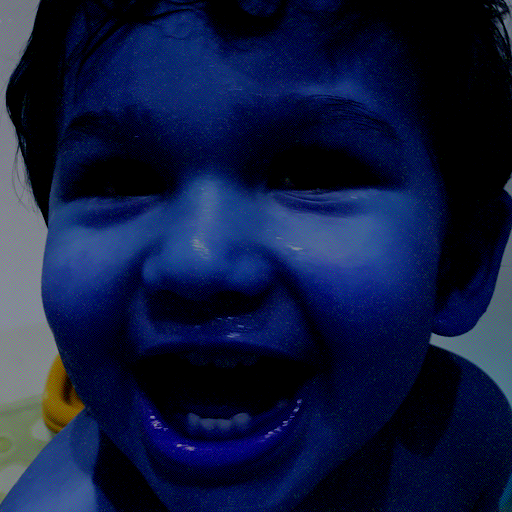

conv2_block1_0_bn (10-iters):
8352133.50(3s),2886771.25(2s),1672996.38(2s),1230351.00(2s),1007861.81(2s),880693.75(2s),800048.19(2s),739191.94(2s),694712.75(2s),664080.12(3s),



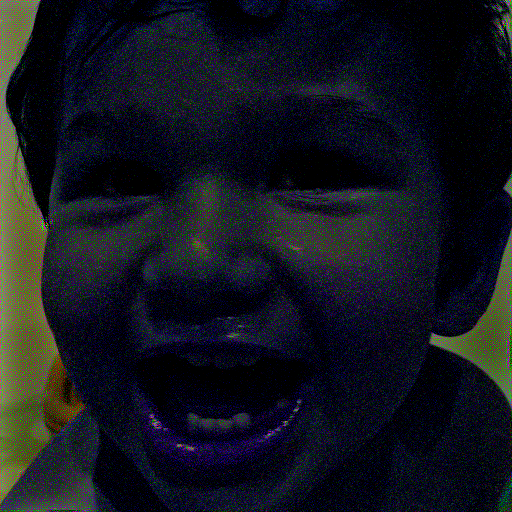

conv3_block1_0_bn (10-iters):
609865.25(11s),209567.25(6s),127669.88(6s),88606.67(6s),68598.13(6s),56993.66(6s),49783.27(6s),44470.70(6s),40711.36(6s),38053.05(6s),



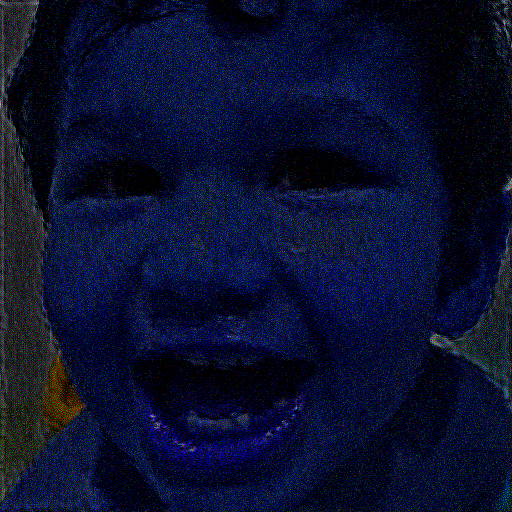

conv4_block1_0_bn (10-iters):
66763.41(16s),34598.15(8s),25477.22(8s),21112.62(9s),18646.19(9s),17037.53(9s),15955.25(9s),15135.75(9s),14491.97(9s),13944.60(9s),



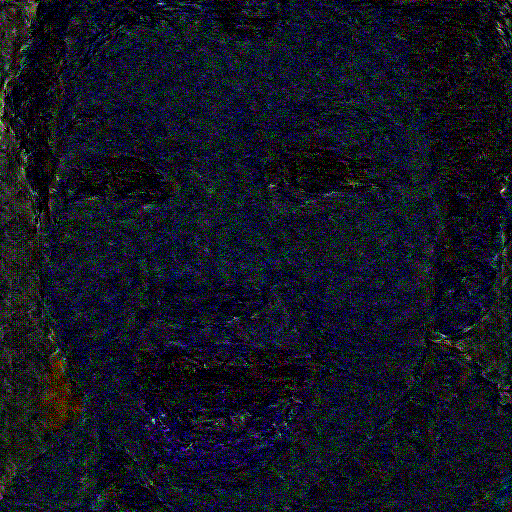

conv5_block1_0_bn (10-iters):
35356.52(22s),19825.91(11s),14685.55(11s),12078.04(11s),10546.08(11s),9512.81(11s),8799.89(11s),8259.17(11s),7845.03(11s),7522.63(11s),



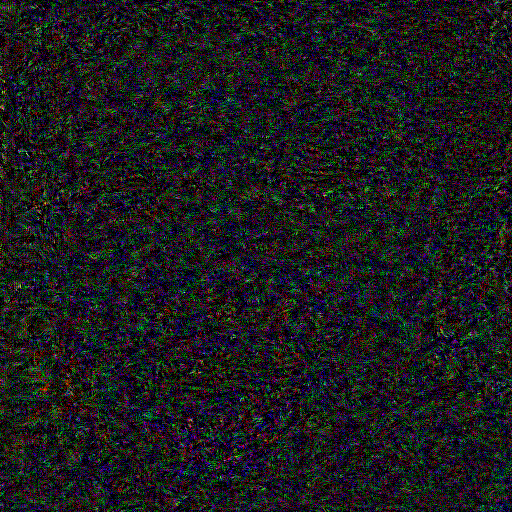

In [54]:
layer_names = ['conv1/bn', 'conv2_block1_0_bn', 'conv3_block1_0_bn',
               'conv4_block1_0_bn', 'conv5_block1_0_bn']
for cnn_layer in layer_names:
  content_image_reconstruction(cnn_layer)

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [15]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['conv2_block1_0_bn']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [0]:
###The style loss
This is where things start to get a bit intricate.

For the style loss, we first define something called a Gram matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. (This is not trivial at all, and I refer you to a paper that attempts to explain the idea.)

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [16]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

Again, in the following code, I've chosen to go with the style features from layers defined in Johnson et al. (2016) rather than Gatys et al. (2015) because I find the end results more aesthetically pleasing. I encourage you to experiment with these choices to see varying results.

In [17]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


###The total variation loss
Now we're back on simpler ground.

If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), you'll find that the output is quite noisy. We thus add another term, called the total variation loss (a regularisation term) that encourages spatial smoothness.

You can experiment with reducing the total_variation_weight and play with the noise-level of the generated image.

In [18]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)


In [19]:
grads = backend.gradients(loss, combination_image)

In [20]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [23]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 20

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 21411396.0
Iteration 0 completed in 2s
Start of iteration 1
Current loss value: 1537284.2
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 896599.6
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 834364.6
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 814757.1
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 806497.9
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 798621.1
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 791867.4
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 784130.1
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 777899.5
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 772071.25
Iteration 10 completed in 3s
Start of iteration 11
Current loss value: 766780.25
Iteration 11 completed in 3s
Start of iteration 12
Current loss value: 761689.56
Ite

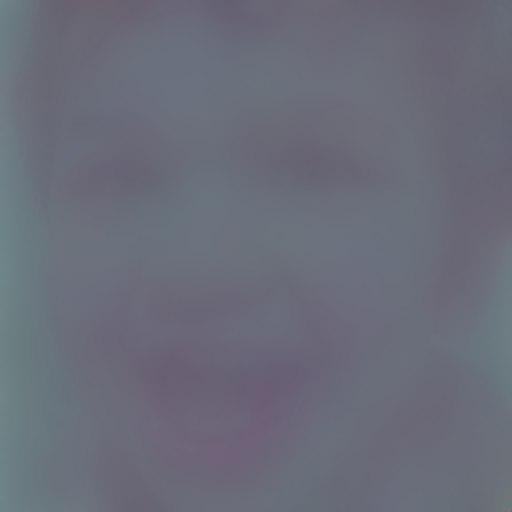

In [24]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)